In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, argparse, os, multiprocessing.pool
from tqdm import tqdm

import pandas as pd
import numpy as np
import torch, librosa
import torch.nn as nn
import ffmpeg, torchaudio
from ffmpeg import Error

/root/anaconda3/envs/torch18/lib/python3.8/site-packages/llvmlite/llvmpy/__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
/root/anaconda3/envs/torch18/lib/python3.8/site-packages/llvmlite/llvmpy/core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
/root/anaconda3/envs/torch18/lib/python3.8/site-packages/llvmlite/llvmpy/passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


## Sample Data

In [3]:
import math

import sys
sys.path.append('/root/mediazen/s2b/src')

from dataset import FaceDataset
from deepspeech import Jangnan
from utils import plot_spectrogram, plot_result

device = 'cuda'

In [4]:
# dataset

data_dir = '/root/mediazen/speech2anim/essentials_1443'
essentials_dir = [d.path for d in os.scandir(data_dir)]
audio_path, shape_path = essentials_dir
audio_path, shape_path

audio_pt = torch.load(audio_path)
shape_pt = torch.load(shape_path)

ds = FaceDataset(audio_pt[2], audio_pt[3], shape_pt[3], shape_pt[4], (audio_pt[1], shape_pt[0]))

In [5]:
dl = torch.utils.data.DataLoader(ds[1288:1291], batch_size=3, num_workers=64, pin_memory=False)

In [6]:
for batch in dl:
    spec, spec_len, blendshape, blendshape_len, idx, timecode = batch
spec = spec.to(device)
spec_len = spec_len.to(device)
blendshape = blendshape.to(device)
blendshape_len = blendshape_len.to(device)
spec.shape, spec_len, blendshape.shape, blendshape_len

(torch.Size([3, 11682, 161]),
 tensor([4914, 4140, 5754], device='cuda:0', dtype=torch.int32),
 torch.Size([3, 7012, 16]),
 tensor([2952, 2489, 3457], device='cuda:0', dtype=torch.int32))

## Power Spectrogram -> DeepSpeech

In [7]:
encoder = Jangnan()
encoder.load_state_dict(torch.load('/root/mediazen/s2b/pretrained/jangnan.pt'))
encoder.to(device)

Jangnan(
  (conv): MaskConv(
    (seq_module): Sequential(
      (0): Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Hardtanh(min_val=0, max_val=20, inplace=True)
      (3): Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Hardtanh(min_val=0, max_val=20, inplace=True)
    )
  )
  (rnns): Sequential(
    (0): BatchRNN(
      (rnn): LSTM(1312, 1024, bidirectional=True)
    )
    (1): BatchRNN(
      (batch_norm): SequenceWise (
      BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
      (rnn): LSTM(1024, 1024, bidirectional=True)
    )
    (2): BatchRNN(
      (batch_norm): SequenceWise (
      BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
      (rnn): LSTM(1024, 1024, bidirec

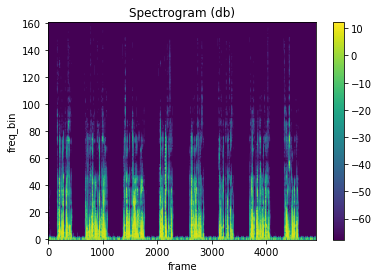

In [9]:
plot_spectrogram(spec[0][:spec_len[0]].T.cpu())

In [10]:
enc_out = encoder(spec, spec_len)
enc_out.shape

torch.Size([5841, 3, 1024])

## Deepspeech -> Interpolate

In [11]:
%cd /root/mediazen/s2b/
from model import GGomYangModel
model = GGomYangModel.load_from_checkpoint('/root/mediazen/speech2anim/ckpt2/epoch=6-step=7055.ckpt')
model.to(device)

/root/mediazen/s2b


GGomYangModel(
  (sum_criterion): MSELoss()
  (jangnan_encoder): Jangnan(
    (conv): MaskConv(
      (seq_module): Sequential(
        (0): Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=0, max_val=20, inplace=True)
        (3): Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): Hardtanh(min_val=0, max_val=20, inplace=True)
      )
    )
    (rnns): Sequential(
      (0): BatchRNN(
        (rnn): LSTM(1312, 1024, bidirectional=True)
      )
      (1): BatchRNN(
        (batch_norm): SequenceWise (
        BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        (rnn): LSTM(1024, 1024, bidirectional=True)
      )
      (2): BatchRNN(
        (batch_norm): SequenceWise (
        BatchNorm1d

In [12]:
interpolate_out = model.interpolate_features(
    enc_out.permute(1, 0, 2).contiguous(), # 1 * 5841 * 1024
    50, 
    60, 
    output_len=len(blendshape[0])) # 7012
interpolate_out.shape

torch.Size([3, 7012, 1024])

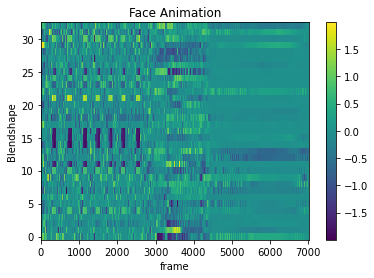

In [15]:
plot_result(interpolate_out[0].T[:33].detach().cpu())

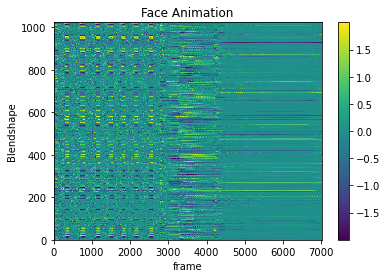

In [16]:
plot_result(interpolate_out[0].T.detach().cpu())

## Interpolate -> FC Layer

In [17]:
out = model.fc(interpolate_out)
out.shape

torch.Size([3, 7012, 16])

In [18]:
ones_list = [torch.ones(length, 16) for length in blendshape_len]
length_mask = torch.nn.utils.rnn.pad_sequence(ones_list, batch_first=True).to(device)

chopped_out = out[:, :max(blendshape_len), :]
chopped_y = blendshape[:, :max(blendshape_len), :]
masked_out = chopped_out * length_mask
masked_out.shape

torch.Size([3, 3457, 16])

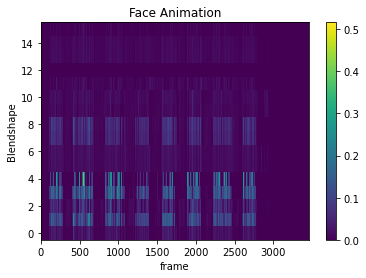

In [19]:
plot_result(masked_out[0].T.detach().cpu())

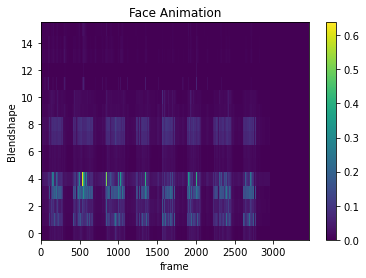

In [20]:
plot_result(chopped_y[0].T.detach().cpu())

## Discriminator

In [21]:
interpolate_out.shape

torch.Size([3, 7012, 1024])

In [22]:
ones_list = [torch.ones(length, 1024) for length in blendshape_len]
length_mask = torch.nn.utils.rnn.pad_sequence(ones_list, batch_first=True).to(device)

chopped_interpolate_out = interpolate_out[:, :max(blendshape_len), :]
masked_interpolate_out = chopped_interpolate_out * length_mask
masked_interpolate_out.shape

torch.Size([3, 3457, 1024])

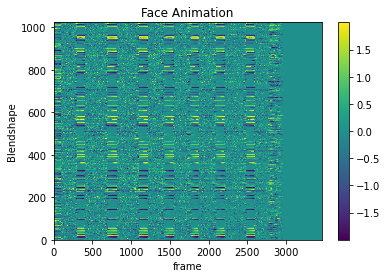

In [23]:
plot_result(masked_interpolate_out[0].T.detach().cpu())

In [59]:
class Dis_block(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
    
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        x = self.block(x)
        return x

In [24]:
masked_interpolate_out.shape, masked_out.shape, chopped_y.shape

(torch.Size([3, 3457, 1024]),
 torch.Size([3, 3457, 16]),
 torch.Size([3, 3457, 16]))

In [28]:
B, T, C = masked_interpolate_out.shape
F = masked_out.shape[-1]
masked_interpolate_out = masked_interpolate_out.view((B, T, int(C/F), F)).permute(0, 2, 1, 3)
masked_interpolate_out.shape

torch.Size([3, 64, 3457, 16])

In [30]:
masked_out = masked_out.unsqueeze(1)
chopped_y = chopped_y.unsqueeze(1)
masked_out.shape, chopped_y.shape

(torch.Size([3, 1, 3457, 16]), torch.Size([3, 1, 3457, 16]))

In [63]:
# fake = torch.cat((masked_interpolate_out, masked_out), 1)
# real = torch.cat((masked_interpolate_out, chopped_y), 1)

# fake.shape, real.shape

(torch.Size([3, 65, 3457, 16]), torch.Size([3, 65, 3457, 16]))

In [65]:
# fake_1 = Dis_block(65, 64, False).to(device)(fake)
# fake_1.shape

torch.Size([3, 64, 1729, 8])

In [66]:
# fake_4 = nn.Sequential(
#     Dis_block(64,128),
#     Dis_block(128,256),
#     Dis_block(256,512)).to(device)(fake_1)
# fake_4.shape

torch.Size([3, 512, 217, 1])

In [67]:
# fake_patch = nn.Conv2d(512,1,3,padding=1).to(device)(fake_4)
# fake_patch = torch.sigmoid(fake_patch)
# fake_patch.shape

torch.Size([3, 1, 217, 1])

In [68]:
# masked_interpolate_out[:,0,:,0].shape

torch.Size([3, 3457])

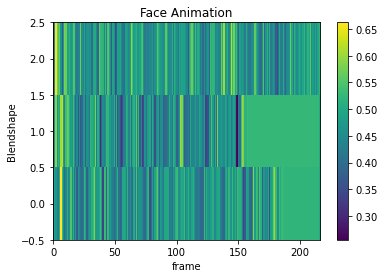

In [69]:
# plot_result(fake_patch[:,0,:,0].detach().cpu())

In [70]:
# real_patch = nn.Sequential(
#     Dis_block(65,64),
#     Dis_block(64,128),
#     Dis_block(128,256),
#     Dis_block(256,512),
#     nn.Conv2d(512,1,3,padding=1),
#     nn.Sigmoid()
#     ).to(device)(real)
# real_patch.shape

torch.Size([3, 1, 217, 1])

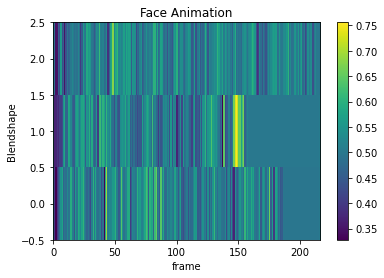

In [71]:
# plot_result(real_patch[:,0,:,0].detach().cpu())

In [83]:
from src.pix2pix import Discriminator, GANLoss

In [84]:
net_D = Discriminator(65).to(device)

In [85]:
fake = torch.cat((masked_interpolate_out, masked_out), 1)
pred_fake = net_D(fake.detach())
# Real
real = torch.cat((masked_interpolate_out, chopped_y), 1)
pred_real = net_D(real)

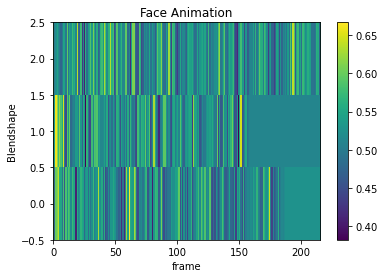

In [86]:
plot_result(pred_fake[:,0,:,0].detach().cpu())

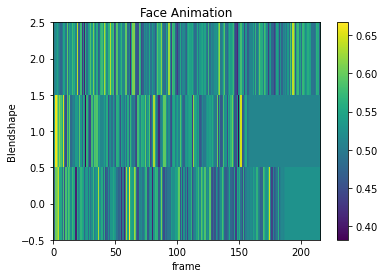

In [87]:
plot_result(pred_real[:,0,:,0].detach().cpu())

In [88]:
criterionGAN = GANLoss().to(device)
criterionL1 = nn.MSELoss(reduction='sum').to(device)

In [89]:
loss_D_fake = criterionGAN(pred_fake, False, blendshape_len)
loss_D_real = criterionGAN(pred_real, True, blendshape_len)
loss_D = (loss_D_fake + loss_D_real) * 0.5

loss_G_GAN = criterionGAN(pred_fake, True, blendshape_len)
lambda_L1 = 100
loss_G_L1 = criterionL1(masked_out, chopped_y)
element_num = torch.sum(blendshape_len) * 16
loss_G_L1 /= element_num 
loss_G = loss_G_GAN + (lambda_L1*loss_G_L1)

In [90]:
loss_D_fake, loss_D_real, loss_D, loss_G_GAN, loss_G_L1, loss_G

(tensor(0.3201, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.2664, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.2932, device='cuda:0', grad_fn=<MulBackward0>),
 tensor(0.2664, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.0014, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.4034, device='cuda:0', grad_fn=<AddBackward0>))